In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from kernels.nn import ImplicitDenseNetKernel
from model.ick import ICK
from model.ick_cmgp import ICK_CMGP
from utils.train import CMGPEnsembleTrainer
from utils.helpers import *

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Generate synthetic data for control and treatment groups

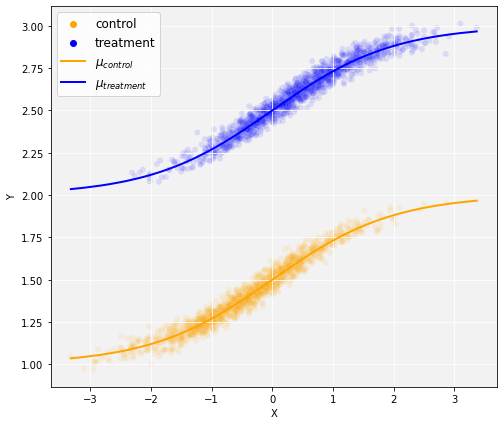

In [2]:
# Generate synthetic data
N = 3000
noise = 0.04
train_test_ratio = 0.7
X = np.random.normal(loc=0.0, scale=1.0, size=N)
T = np.random.binomial(n=1, p=[1/(1 + np.exp(-s)) for s in X])
df = pd.DataFrame(np.stack([X,T], axis=1), columns=['X','T'])
df['Group'] = df.apply(lambda row: 'control' if row['T'] == 0 else 'treatment', axis=1)
df['mu0'] = df.apply(lambda row: 1.0 + 1/(1 + np.exp(-row['X'])), axis=1)
df['mu1'] = df.apply(lambda row: 2.0 + 1/(1 + np.exp(-row['X'])), axis=1)
df['Y0'] = df.apply(lambda row: row['mu0'] + np.random.normal(loc=0.0, scale=noise), axis=1)
df['Y1'] = df.apply(lambda row: row['mu1'] + np.random.normal(loc=0.0, scale=noise), axis=1)
df['Y'] = df.apply(lambda row: row['Y0'] if row['T'] == 0 else row['Y1'], axis=1)

# Visualize data
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
ax.set_facecolor('#F2F2F2')
ax.grid(color='white')
sns.scatterplot(data=df, x='X', y='Y', hue='Group', alpha=0.1, palette={'control':'orange','treatment':'blue'})
ax.plot(sorted(df['X']), [x for _,x in sorted(zip(df['X'],df['mu0']))], color='orange', lw=2, label='$\mu_{control}$')
ax.plot(sorted(df['X']), [x for _,x in sorted(zip(df['X'],df['mu1']))], color='blue', lw=2, label='$\mu_{treatment}$')
ax.legend(fontsize=12)

In [3]:
# Training data
X_train = df['X'][:int(N*train_test_ratio)].to_numpy()[:,None]
T_train = df['T'][:int(N*train_test_ratio)].to_numpy()[:,None]
Y_train = df['Y'][:int(N*train_test_ratio)].to_numpy()[:,None]
mu0_train = df['mu0'][:int(N*train_test_ratio)].to_numpy()[:,None]
mu1_train = df['mu1'][:int(N*train_test_ratio)].to_numpy()[:,None]

# Test data
X_test = df['X'][int(N*train_test_ratio):].to_numpy()[:,None]
T_test = df['T'][int(N*train_test_ratio):].to_numpy()[:,None]
Y_test = df['Y'][int(N*train_test_ratio):].to_numpy()[:,None]
mu0_test = df['mu0'][int(N*train_test_ratio):].to_numpy()[:,None]
mu1_test = df['mu1'][int(N*train_test_ratio):].to_numpy()[:,None]
mu_test = mu1_test - mu0_test

# Initialize dataloaders
data_train = [X_train, T_train]
data_test = [X_test, T_test]
data_generators = create_generators_from_data(data_train, Y_train, data_test, Y_test)

# 2. Define ICK-CMGP model

$Y_0(x) = \alpha_1 f_1(x) + \alpha_2 f_2(x) + 0 \\$
$Y_1(x) = 0 + \alpha_2 f_2(x) + \alpha_3 f_3(x)$

In [4]:
# Y0(x) = alpha1 * f1(x) + alpha2 * f2(x) + 0 * f3(x)
# Y1(x) = 0 * f1(x) + alpha2 * f2(x) + alpha3 * f3(x)
alpha1, alpha2, alpha3 = 1.0, 1.0, 1.0
f1 = ICK(
    kernel_assignment=['ImplicitDenseNetKernel'],
    kernel_params={
        'ImplicitDenseNetKernel':{
            'input_dim': X_train.shape[1],
            'latent_feature_dim': 16,
            'num_blocks': 1, 
            'num_layers_per_block': 1, 
            'num_units': 64
        }
    }
)
f2 = ICK(
    kernel_assignment=['ImplicitDenseNetKernel'],
    kernel_params={
        'ImplicitDenseNetKernel':{
            'input_dim': X_train.shape[1],
            'latent_feature_dim': 16,
            'num_blocks': 1, 
            'num_layers_per_block': 1, 
            'num_units': 64
        }
    }
)
f3 = ICK(
    kernel_assignment=['ImplicitDenseNetKernel'],
    kernel_params={
        'ImplicitDenseNetKernel':{
            'input_dim': X_train.shape[1],
            'latent_feature_dim': 16,
            'num_blocks': 1, 
            'num_layers_per_block': 1, 
            'num_units': 64
        }
    }
)
num_estimators = 100
ensemble = [ICK_CMGP(
    control_components=[f1], treatment_components=[f2], shared_components=[f3],
    control_coeffs=[alpha1], treatment_coeffs=[alpha2], shared_coeffs=[alpha3]
) for _ in range(num_estimators)]

# 3. Training and evaluation of ICK-CMGP model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 5e-7, 
    'momentum': 0.9,
    'weight_decay': 0
}
epochs, patience = 100, 10
trainer = CMGPEnsembleTrainer(
    model=ensemble,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience, 
    treatment_index=1   # The index of "T_train" in "data_train" is 1
)
trainer.train()

PEHE:             0.0531


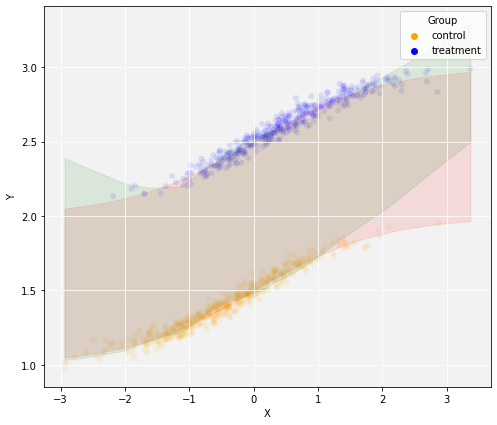

In [9]:
mean_test_pred, std_test_pred, y_test_true = trainer.predict()
mu_test_pred = mean_test_pred[:,1] - mean_test_pred[:,0]

# PEHE
pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
print('PEHE:             %.4f' % (pehe_test))

# Visualize PEHE
test_df = df.loc[int(N*train_test_ratio):]
fig = plt.figure(figsize=(8,7))
ax = plt.gca()
ax.set_facecolor('#F2F2F2')
ax.grid(color='white')
sns.scatterplot(data=test_df, x='X', y='Y', hue='Group', alpha=0.1, palette={'control':'orange','treatment':'blue'})
ax.fill_between(
    sorted(test_df['X']), 
    [x for _,x in sorted(zip(test_df['X'],test_df['mu0']))],
    [x for _,x in sorted(zip(test_df['X'],test_df['mu1']))],
    color='red',
    alpha=0.1
)
ax.fill_between(
    sorted(test_df['X']), 
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,0]))],
    [x for _,x in sorted(zip(test_df['X'],mean_test_pred[:,1]))],
    color='green',
    alpha=0.1
)